In [1]:
from eolearn.core import EOPatch, FeatureType, MergeEOPatchesTask
from eolearn.io import ImportFromTiffTask

import os
import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rioxarray as rx
from shapely.geometry import box
from rasterio.enums import Resampling

from sentinelhub import BBox

In [2]:
sentinel_archives_root = '../data/sentinel'
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
sentinel_archives

['../data/sentinel\\S2A_MSIL1C_20210916T170941_N0301_R112_T15TVM_20210916T210302.SAFE',
 '../data/sentinel\\S2A_MSIL1C_20211016T171311_N0301_R112_T15TVM_20211016T191815.SAFE',
 '../data/sentinel\\S2A_MSIL1C_20211125T171641_N0301_R112_T15TVM_20211125T191313.SAFE',
 '../data/sentinel\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE',
 '../data/sentinel\\S2B_MSIL1C_20211120T171619_N0301_R112_T15TVM_20211120T192246.SAFE']

In [3]:
sentinel_2_1lc_bands = {
    0: 'B01',
    1: 'B02',
    2: 'B03',
    3: 'B04',
    4: 'B05',
    5: 'B06',
    6: 'B07',
    7: 'B08',
    8: 'B8A',
    9: 'B09',
    10: 'B10',
    11: 'B11',
    12: 'B12',
}


def extract_meta_from_path(sentinel_archive):
    meta_parts = os.path.basename(sentinel_archive).split('.')[0].split('_')
    mission = meta_parts[0]
    level = meta_parts[1][-3:]
    acq_time = datetime.datetime.strptime(meta_parts[2], '%Y%m%dT%H%M%S')

    return mission, level, acq_time


def construct_eopatch_from_sentinel_archive(sentinel_archive, bbox: BBox = None, target_shape=None, target_resolution=10, resampling_method=Resampling.bilinear):
    eopatch = EOPatch()

    mission, level, acq_time = extract_meta_from_path(sentinel_archive)

    bands_pattern = f'{sentinel_archive}/**/*.jp2'
    band_paths = glob.glob(bands_pattern, recursive=True)
    bands_paths = [(os.path.basename(path).split('.')[0].split('_')[-1], path) for path in band_paths]

    band_data_arrays = []
    agreed_bbox = None if bbox is None else bbox
    agreed_shape = None if target_shape is None else target_shape
    used_crs = None
    for bandname in sentinel_2_1lc_bands.values():
        res_bandpath = [path for (bn, path) in bands_paths if bn == bandname]
        if len(res_bandpath) > 0:
            band_da = rx.open_rasterio(res_bandpath[0], driver='JP2OpenJPEG')

            if used_crs is None and bbox is None:
                used_crs = band_da.rio.crs
            elif used_crs is None:
                used_crs = rio.crs.CRS.from_epsg(bbox.crs.epsg)

            if bbox is not None:
                if bbox.crs.epsg != band_da.rio.crs.to_epsg():
                    bbox = bbox.transform(band_da.rio.crs.to_epsg())
                band_da = band_da.rio.clip_box(*bbox)
            else:
                agreed_bbox = band_da.rio.bounds()

            (source_resolution, _) = band_da.rio.resolution()
            source_resolution = abs(source_resolution)
            # reprojecting and clipping can lead to an unequal amount of pixels per band
            # to circumvent this we can either supply a shape as the parameter or
            # fix a shape after going through the first band
            if agreed_shape is None and source_resolution != target_resolution:
                band_da = band_da.rio.reproject(
                    used_crs,
                    resolution=(target_resolution, target_resolution),
                    resampling=resampling_method
                )
            elif agreed_shape is not None and (source_resolution != target_resolution or band_da.rio.shape != agreed_shape):
                band_da = band_da.rio.reproject(
                    used_crs,
                    shape=agreed_shape,
                    resampling=resampling_method
                )

            # all bands need to have the same shape
            # we fix this after working with the first band
            # if no shape is given as a parameter
            if agreed_shape is None:
                agreed_shape = band_da.rio.shape

            band_data_arrays.append(band_da.values[0])

    if len(band_data_arrays) < 1:
        raise ValueError('No bands found in sentinel archive')

    temporal_dim = 1 # only one timestamp
    height, width = band_data_arrays[0].shape
    channels = len(band_data_arrays)
    eopatch_shape = temporal_dim, height, width, channels

    band_data = np.stack(band_data_arrays, axis=-1).reshape(*eopatch_shape)

    eopatch.bbox = BBox(agreed_bbox, crs=used_crs.to_epsg())
    eopatch.timestamp = [acq_time]
    eopatch.add_feature(FeatureType.DATA, f'{level}_data', band_data)
    eopatch.meta_info['mission'] = mission

    return eopatch

In [4]:
import earthpy.plot as ep


def plot_eopatch(eopatch, rgb_bands, feature, time_index=0, stretch=True, ax=None):
    bands_at_timestamp = eopatch[feature][time_index,:,:,:]
    _, _, bands = bands_at_timestamp.shape
    single_bands = [bands_at_timestamp[:,:,x] for x in range(bands)]

    return ep.plot_rgb(np.stack(single_bands), rgb=rgb_bands, stretch=stretch, ax=ax)


true_color = [3,2,1]
false_color = [7, 3, 2]


def plot_single_band(eopatch: EOPatch, feature, band_index=0, time_index=0, stretch=True, figsize=(10,10), cmap='gray'):
    if len(eopatch[feature].shape) > 3:
        band_data = eopatch[feature][time_index,:,:,band_index]
    else:
        band_data = eopatch[feature][:,:,band_index]
    vmin = None
    vmax = None
    if stretch:
        vmin, vmax = np.percentile(band_data, [5, 95])
    _, ax = plt.subplots(1, 1, figsize=figsize)

    return ax.imshow(band_data, cmap=cmap, vmin=vmin, vmax=vmax)

In [5]:
def get_products_by_level(sentinel_archives, level):
    products = [(extract_meta_from_path(archive)[2], archive) for archive in sentinel_archives if extract_meta_from_path(archive)[1] == level]
    products.sort(key=lambda x: x[0])
    
    return products


l1c_products = get_products_by_level(sentinel_archives, 'L1C')

In [6]:
from eolearn.core import EOTask
import rasterio as rio
from rasterio import MemoryFile


class ReprojecRastertTask(EOTask):
    def __init__(self, feature, target_resolution=None, target_width=None, target_height=None, target_crs=None, driver='GTiff', resampling=Resampling.bilinear):
        if target_resolution is None and (target_width is None or target_height is None):
            raise ValueError('Either target_resolution or target_width and target_height must be provided')

        self.feature = feature
        self.target_crs = target_crs
        self.target_width = target_width
        self.target_height = target_height
        self.target_resolution = target_resolution
        self.driver = driver
        self.resampling = resampling

    def execute(self, eopatch):
        times = None
        # timeless features only have 3 dimensions
        if len(eopatch[self.feature].shape) == 3:
            height, width, channels = eopatch[self.feature].shape
        else:
            times, height, width, channels = eopatch[self.feature].shape

        dtype = eopatch[self.feature].dtype
        crs =  rio.crs.CRS.from_epsg(eopatch.bbox.crs.epsg)
        transform = rio.transform.from_bounds(*eopatch.bbox, width, height)

        agreed_bbox = None
        single_frame = None
        frames = []
        repeats = 1 if times is None else times
        target_crs = self.target_crs if self.target_crs is not None else crs
        for i in range(repeats):
            with MemoryFile() as src_memfile:
                with src_memfile.open(driver=self.driver, height=height,
                                      width=width, count=channels, dtype=dtype,
                                      crs=crs, transform=transform) as src:

                    for channel in range(channels):
                        if times is None:
                            src.write(eopatch[self.feature][:,:,channel], channel + 1)
                        else:
                            src.write(eopatch[self.feature][i,:,:,channel], channel + 1)

                    target_transform, target_width, target_height = (
                        rio.warp.calculate_default_transform(
                            src.crs, target_crs, src.width, src.height, *src.bounds,
                            dst_width=self.target_width, dst_height=self.target_height
                        ) if self.target_resolution is None else
                        rio.warp.calculate_default_transform(
                            src.crs, target_crs, src.width, src.height, *src.bounds,
                            resolution=self.target_resolution
                        )
                    )
                    kwargs = src.meta.copy()
                    kwargs.update({
                        'crs': target_crs,
                        'transform': target_transform,
                        'width': target_width,
                        'height': target_height
                    })
                    
                    with MemoryFile() as dst_memfile:
                        with dst_memfile.open(**kwargs) as dst:
                            for i in range(1, src.count + 1):
                                rio.warp.reproject(
                                    source=rio.band(src, i),
                                    destination=rio.band(dst, i),
                                    src_transform=src.transform,
                                    src_crs=src.crs,
                                    dst_transform=target_transform,
                                    dst_crs=target_crs,
                                    resampling=self.resampling
                                )

                            if agreed_bbox is None:
                                agreed_bbox = BBox(dst.bounds, crs=target_crs.to_epsg())

                            if times is not None:
                                frames.append(np.moveaxis(dst.read(), 0, -1))
                            else:
                                single_frame = np.moveaxis(dst.read(), 0, -1)

        result_eopatch = eopatch.copy()
        result_eopatch[self.feature] = np.stack(frames, axis=0) if times is not None else single_frame
        result_eopatch.bbox = agreed_bbox

        return result_eopatch

In [7]:
class AppendBathyTimelessDataMask(EOTask):
    def __init__(self, src_feature, dst_feature_name="bathy_data_mask", band_index=0):
        self.src_feature = src_feature
        self.dst_feature_name = dst_feature_name
        self.band_index = band_index

    def execute(self, eopatch):
        if len(eopatch[self.src_feature].shape) > 3:
            raise ValueError('Feature {} is not timeless'.format(self.src_feature))

        bathy_data = np.copy(eopatch[self.src_feature][:,:,self.band_index])
        bathy_data[bathy_data >= 0] = 0
        bathy_data[bathy_data < 0] = 1
        bathy_data = bathy_data.astype(np.uint8)

        result_eopatch = eopatch.copy()
        result_eopatch[FeatureType.MASK_TIMELESS, self.dst_feature_name] = (
            np.atleast_3d(bathy_data)
        )

        return result_eopatch

In [8]:
from eolearn.core import LinearWorkflow

millie_lacs_eop = EOPatch()

import_millie_lacs = ImportFromTiffTask((FeatureType.DATA_TIMELESS, 'bathy_data'), '../data/mille_lacs.tiff')
reproject_bathy = ReprojecRastertTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    target_resolution=(10, 10),
)
append_bathy_data_mask = AppendBathyTimelessDataMask((FeatureType.DATA_TIMELESS, 'bathy_data'), band_index=0)

workflow = LinearWorkflow(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
)

millie_lacs_eop = workflow.execute().eopatch()
millie_lacs_eop

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless: {
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp: []
)

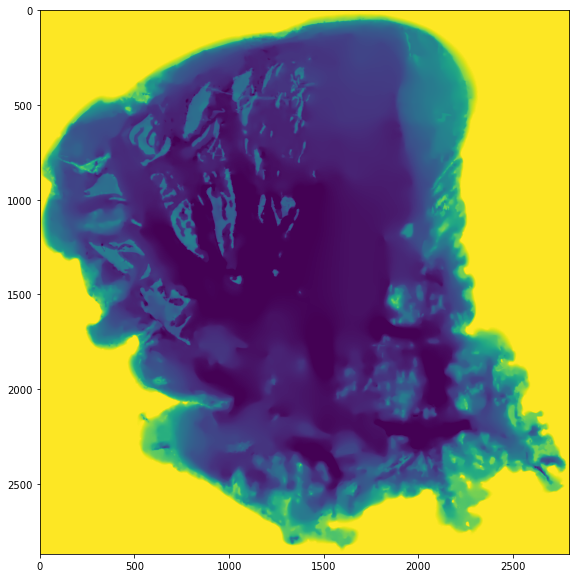

In [9]:
plot_single_band(millie_lacs_eop, (FeatureType.DATA_TIMELESS, 'bathy_data'), cmap='viridis')

In [10]:
safe_archive_path = l1c_products[1][1]
height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
safe_eopatch = construct_eopatch_from_sentinel_archive(safe_archive_path, target_shape=(height, width), bbox=millie_lacs_eop.bbox)
safe_eopatch

EOPatch(
  data: {
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    mission: 'S2A'
  }
  bbox: BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp: [datetime.datetime(2021, 10, 16, 17, 13, 11)]
)

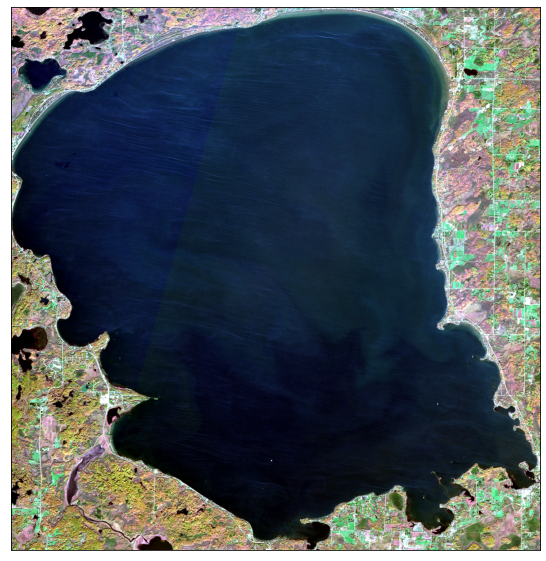

<AxesSubplot:>

In [11]:
plot_eopatch(safe_eopatch, rgb_bands=true_color, feature=(FeatureType.DATA, "L1C_data"), stretch=True)

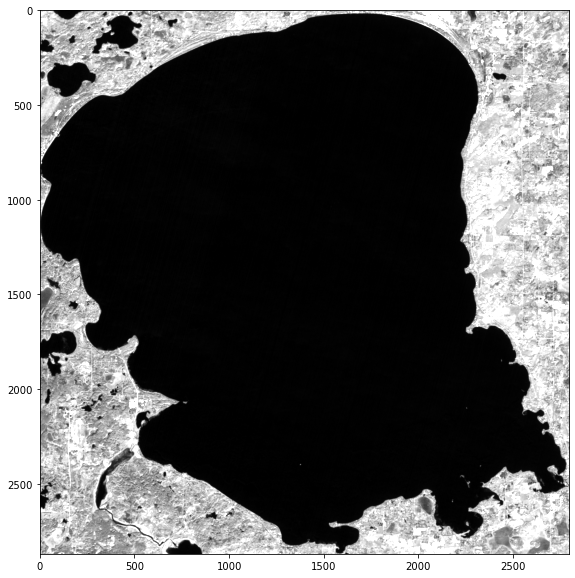

In [12]:
plot_single_band(safe_eopatch, (FeatureType.DATA, "L1C_data"), band_index=12, time_index=0, stretch=True)

In [13]:
merge_patches_task = MergeEOPatchesTask()
merged_eop = merge_patches_task.execute(millie_lacs_eop, safe_eopatch)
merged_eop

EOPatch(
  data: {
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless: {
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    mission: 'S2A'
  }
  bbox: BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp: [datetime.datetime(2021, 10, 16, 17, 13, 11)]
)

### Validate SAFE archive to EOPatch Against SentinelHub

In [ ]:
from eolearn.core import SaveTask, LinearWorkflow
from eolearn.io import SentinelHubInputTask
from sentinelhub.data_collections import DataCollection

roi_bbox = band_eopatch.bbox
time_interval = ("2021-11-23", "2021-11-26")
maxcc = 0.3
resolution = 20
time_difference = datetime.timedelta(hours=2)

input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    bands_feature=(FeatureType.DATA, "L1C_data"),
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    # config=config,
    max_threads=3,
)

save_task = SaveTask("io_validation_example", overwrite_permission=2, compress_level=1)

workflow_nodes = [input_task, save_task]
workflow = LinearWorkflow(workflow_nodes)

In [ ]:
result = workflow.execute({
    input_task: {"bbox": roi_bbox, "time_interval": time_interval},
    save_task: {"eopatch_folder": "../data/eopatches"}
})

result_eopatch = result.eopatch()
result_eopatch

EOPatch(
  data: {
    L1C_data: numpy.ndarray(shape=(1, 1535, 1497, 13), dtype=float32)
  }
  mask: {
    dataMask: numpy.ndarray(shape=(1, 1535, 1497, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.3
    size_x: 1497
    size_y: 1535
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2021, 11, 23, 0, 0), datetime.datetime(2021, 11, 26, 23, 59, 59))
  }
  bbox: BBox(((435481.30653902073, 5105408.316629673), (465412.97317830625, 5136108.2147320695)), crs=CRS('32615'))
  timestamp: [datetime.datetime(2021, 11, 25, 17, 20, 52)]
)

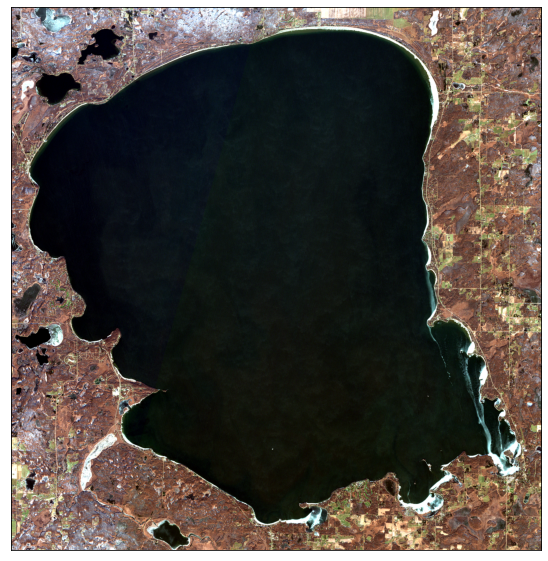

<AxesSubplot:>

In [ ]:
plot_eopatch(result_eopatch, rgb_bands=true_color, feature=(FeatureType.DATA, "L1C_data"))

In [ ]:
result_eopatch.save("../data/eopatches/io_validation_example.eopatch")